Author: Kaveh Mahdavi <kavehmahdavi74@yahoo.com>
License: BSD 3 clause
last update: 28/12/2022

# Object Recognition in Images

In [74]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import load_model
import urllib
import itertools
from IPython.display import display, HTML

In [75]:
# Classes
class BColors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


# Functions
def _normalize(data):
    return data.astype("float32") / 255.0


def _evaluate(model, x_test, y_test, _print=False):
    """

    :param model:
    :param x_test:
    :param y_test:
    :return:
    """
    acc = model.evaluate(x_test, y_test)
    if _print:
        print("Test set loss : ", acc[0])
        print("Test set accuracy :", acc[1] * 100)
    else:
        return acc


def perform_plot(histories, _cnns, epoch, metrics=['accuracy', 'val_accuracy'], margin=0.05):
    """ Plot the model performance

    """
    y_lims = []
    epoch_range = range(1, epoch + 1)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5)
    for _history, _cnn, _ax in zip(histories, cnns, fig.axes):
        for _metric in metrics:
            _ax.plot(epoch_range, _history.history[_metric])
        _ax.set(xlabel='Epoch',
                ylabel=_metric[0],
                title='Model {} (Layers = {})'.format(_cnn.name, len(_cnn.layers)))
        y_lims.append(list(itertools.chain(*[_history.history.get(key) for key in metrics])))

    y_lims = np.array(y_lims)
    for _ax in fig.axes:
        _ax.set_ylim((y_lims.min() * (1 - margin), y_lims.max() * (1 + margin)))

    plt.legend(['Train', 'Val'], loc='center right')
    plt.suptitle('Classification {}'.format(metrics[0].upper()))
    fig.set_size_inches(16, 4)
    plt.subplots_adjust(top=0.8)


def plot_deepness(histories, _cnns):
    """ Plot the model deepness vs accuracy and loss

    """
    deep_df = pd.DataFrame(columns=['deepness', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])
    for _history, _cnn in zip(histories, cnns):
        deep_df.loc[_cnn.name] = {'deepness': len(_cnn.layers),
                                  'loss': _history.history['loss'][-1],
                                  'accuracy': _history.history['accuracy'][-1],
                                  'val_loss': _history.history['val_loss'][-1],
                                  'val_accuracy': _history.history['val_accuracy'][-1]}

    fig, (ax1, ax2) = plt.subplots(ncols=2)

    ax1.plot(deep_df['deepness'], deep_df['accuracy'])
    ax1.plot(deep_df['deepness'], deep_df['val_accuracy'])
    ax1.set(xlabel='#Layers',
            ylabel='Accuracy',
            title='Accuracy vs. Deepness ')

    ax2.plot(deep_df['deepness'], deep_df['loss'])
    ax2.plot(deep_df['deepness'], deep_df['val_loss'])
    ax2.set(xlabel='#Layers',
            ylabel='Loss',
            title='Loss vs. Deepness ')

    plt.legend(['Train', 'Val'], loc='center right')
    fig.set_size_inches(16, 4)
    plt.subplots_adjust(top=0.8)


def _predict(filename, models, classes):
    # load and display image
    img = load_img(filename, target_size=(32, 32))
    plt.imshow(img)

    # convert to array
    # reshape into a single sample with 3 channels
    img = img_to_array(img)
    img = img.reshape(1, 32, 32, 3)

    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0

    acc_matrix = pd.DataFrame(index=classes,
                              columns=[item.name for item in models])
    # predicting the results
    for __model in models:
        acc_matrix[__model.name] = __model.predict(img)[0]

    print(BColors.OKGREEN + "Predictions of this images are:" + BColors.ENDC)
    display(HTML(acc_matrix.to_html()))
    print(BColors.OKGREEN + 'The image given as input is:' + BColors.ENDC)


def _predicts(_model, images, classes):
    acc_matrix = pd.DataFrame(index=classes, columns=images)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
    for _ax, _img, __name in zip(fig.axes, images, images):
        # load and display image
        img = load_img("images/{}.jpg".format(_img), target_size=(32, 32))
        _ax.imshow(img)

        # convert to array
        # reshape into a single sample with 3 channels
        img = img_to_array(img)
        img = img.reshape(1, 32, 32, 3)

        # prepare pixel data
        img = img.astype('float32')
        img = img / 255.0

        acc_matrix[__name] = _model.predict(img)[0]

    fig.set_size_inches(16, 4)
    plt.subplots_adjust(top=0.8)

    print(BColors.OKGREEN + "Predictions of these images are:" + BColors.ENDC)
    display(HTML(acc_matrix.to_html()))
    print(BColors.OKGREEN + 'The images given as input is:' + BColors.ENDC)


def round_dict(_dict, _k=2):
    return {k: round(v[-1], _k) for k, v in _dict.items()}

## Load Dataset

* The **CIFAR-10** dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
* The dataset is divided into five training batches and one test batch, each with 10000 images.
* The test batch contains exactly 1000 randomly-selected images from each class.
* The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another.
* Between them, the training batches contain exactly 5000 images from each class.

x_train dimensions :  (50000, 32, 32, 3)
x_test dimensions  :  (10000, 32, 32, 3)
y_train dimensions :  (50000, 10)
y_test dimensions  :  (10000, 10)


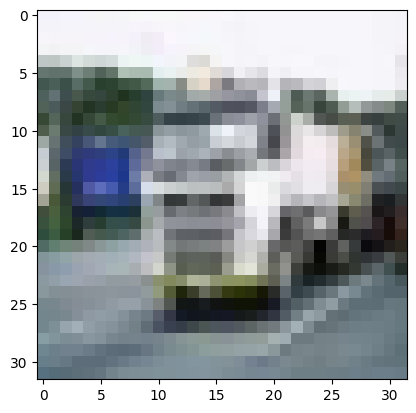

In [76]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Treat categorical columns
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("x_train dimensions : ", x_train.shape)
print("x_test dimensions  : ", x_test.shape)
print("y_train dimensions : ", y_train.shape)
print("y_test dimensions  : ", y_test.shape)

plt.imshow(x_train[1000])

## Data Augmentation & Transformation

In [77]:
# Normalize
x_train = _normalize(x_train)
x_test = _normalize(x_test)

In [ ]:
# Augmentation & Normalize
_validation_split = 0.2
aug_data = ImageDataGenerator(featurewise_center=True,
                              featurewise_std_normalization=True,
                              rotation_range=15,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              validation_split=_validation_split)

aug_data.fit(x_train)

In [10]:
# Prepared Data Summary
print("x_train dimensions : ", x_train.shape)
print("y_train dimensions : ", y_train.shape)
print("x_test dimensions  : ", x_test.shape)
print("y_test dimensions  : ", y_test.shape)

x_train dimensions :  (50000, 32, 32, 3)
y_train dimensions :  (50000, 10)
x_test dimensions  :  (10000, 32, 32, 3)
y_test dimensions  :  (10000, 10)


## Models Definition

I designed **CDNN** models with different level of the deepness.

In [11]:
# Model with 2 convolution layers
cnn1 = Sequential([Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
                   Conv2D(32, (3, 3), activation='relu', padding='same'),
                   MaxPooling2D((2, 2)),
                   Flatten(),
                   Dense(128, activation='relu'),
                   Dense(10, activation='softmax')],
                  name='CNN1')

# Model with 4 Convolution layers
cnn2 = Sequential([Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
                   Conv2D(32, (3, 3), activation='relu', padding='same'),
                   MaxPooling2D((2, 2)),
                   Conv2D(64, (3, 3), activation='relu', padding='same'),
                   Conv2D(64, (3, 3), activation='relu', padding='same'),
                   MaxPooling2D((2, 2)),
                   Flatten(),
                   Dense(128, activation='relu'),
                   Dense(10, activation='softmax')],
                  name='CNN2')

# Model with 6 convolution layers with 32 , 64 and 128 filters respectively
cnn3 = Sequential([Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
                   Conv2D(32, (3, 3), activation='relu', padding='same'),
                   MaxPooling2D((2, 2)),
                   Conv2D(64, (3, 3), activation='relu', padding='same'),
                   Conv2D(64, (3, 3), activation='relu', padding='same'),
                   MaxPooling2D((2, 2)),
                   Conv2D(128, (3, 3), activation='relu', padding='same'),
                   Conv2D(128, (3, 3), activation='relu', padding='same'),
                   MaxPooling2D((2, 2)),
                   Flatten(),
                   Dense(128, activation='relu'),
                   Dense(10, activation='softmax')],
                  name='CNN3')
#Model with Adding Dropouts
cnn4 = Sequential([Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                          input_shape=(32, 32, 3)),
                   Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
                   MaxPooling2D((2, 2)),
                   Dropout(0.2),
                   Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
                   Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
                   MaxPooling2D((2, 2)),
                   Dropout(0.2),
                   Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
                   Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
                   MaxPooling2D((2, 2)),
                   Dropout(0.3),
                   Flatten(),
                   Dense(128, activation='relu'),
                   Dense(10, activation='softmax')],
                  name='CNN4')

# Adding Batch Normalization and Regularization
weight_decay = 1e-4
cnn5 = Sequential([Conv2D(32, (3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(32, 32, 3)),
                   BatchNormalization(),
                   Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                          padding='same'),
                   BatchNormalization(),
                   MaxPooling2D((2, 2)),
                   Dropout(0.2),
                   Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                          padding='same'),
                   BatchNormalization(),
                   Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                          padding='same'),
                   BatchNormalization(),
                   MaxPooling2D((2, 2)),
                   Dropout(0.3),
                   Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                          padding='same'),
                   BatchNormalization(),
                   Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                          padding='same'),
                   BatchNormalization(),
                   MaxPooling2D((2, 2)),
                   Dropout(0.3),
                   Flatten(),
                   Dense(128, activation='relu'),
                   Dense(10, activation='softmax')],
                  name='CNN5')

cnns = [cnn1, cnn2, cnn3, cnn4, cnn5]

for _cnn in cnns:
    print(BColors.OKBLUE + "\nThe summary of:" + BColors.ENDC)
    _cnn.summary()


The summary of:
Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                             

### Compile & Train Models

In [12]:
epoch, batch_size = 18, 32
history_list = []
for _cnn in cnns:
    opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    _cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    __history = _cnn.fit(aug_data.flow(x_train, y_train, batch_size=32, subset='training'),
                         steps_per_epoch=len(x_train) * (1 - _validation_split) / batch_size,
                         validation_data=aug_data.flow(x_train, y_train, batch_size=8, subset='validation'),
                         epochs=epoch,
                         verbose=1)
    history_list.append(__history)
    print(BColors.OKGREEN +
          "Model {} was trained successfully by {} epoch, {}.".format(_cnn.name, epoch, round_dict(__history.history)) +
          BColors.ENDC)

Epoch 1/18
1250/1250 [==============================] - 147s 116ms/step - loss: 1.7445 - accuracy: 0.3807 - val_loss: 1.5127 - val_accuracy: 0.4585
Epoch 2/18
1250/1250 [==============================] - 135s 108ms/step - loss: 1.4380 - accuracy: 0.4843 - val_loss: 1.3445 - val_accuracy: 0.5166
Epoch 3/18
1250/1250 [==============================] - 131s 104ms/step - loss: 1.3187 - accuracy: 0.5313 - val_loss: 1.2659 - val_accuracy: 0.5511
Epoch 4/18
1250/1250 [==============================] - 132s 106ms/step - loss: 1.2446 - accuracy: 0.5572 - val_loss: 1.1871 - val_accuracy: 0.5734
Epoch 5/18
1250/1250 [==============================] - 133s 107ms/step - loss: 1.1761 - accuracy: 0.5842 - val_loss: 1.1468 - val_accuracy: 0.5916
Epoch 6/18
1250/1250 [==============================] - 132s 105ms/step - loss: 1.1251 - accuracy: 0.6000 - val_loss: 1.0882 - val_accuracy: 0.6174
Epoch 7/18
1250/1250 [==============================] - 131s 105ms/step - loss: 1.0789 - accuracy: 0.6190 - val_

### Compare the Models Performance

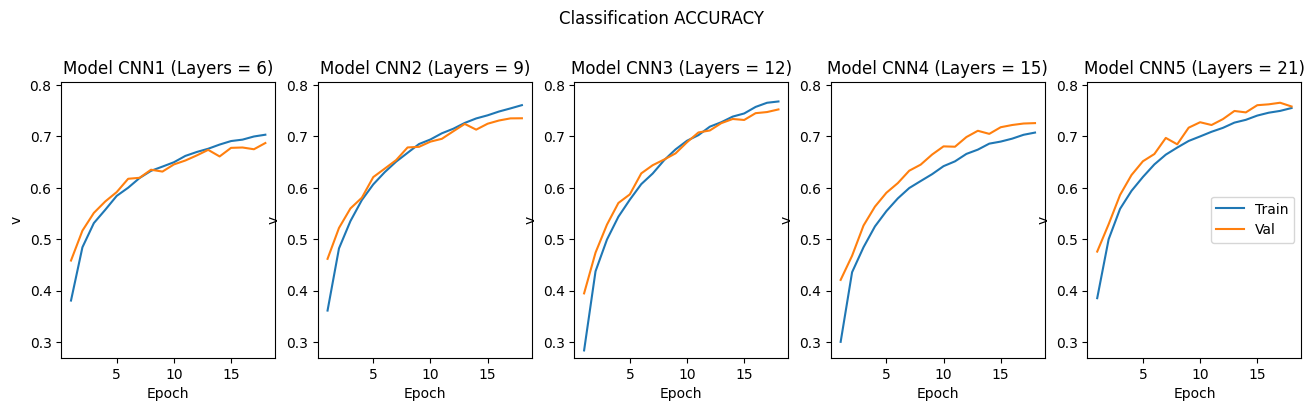

In [21]:
perform_plot(history_list, cnns, epoch, metrics=['accuracy', 'val_accuracy'])

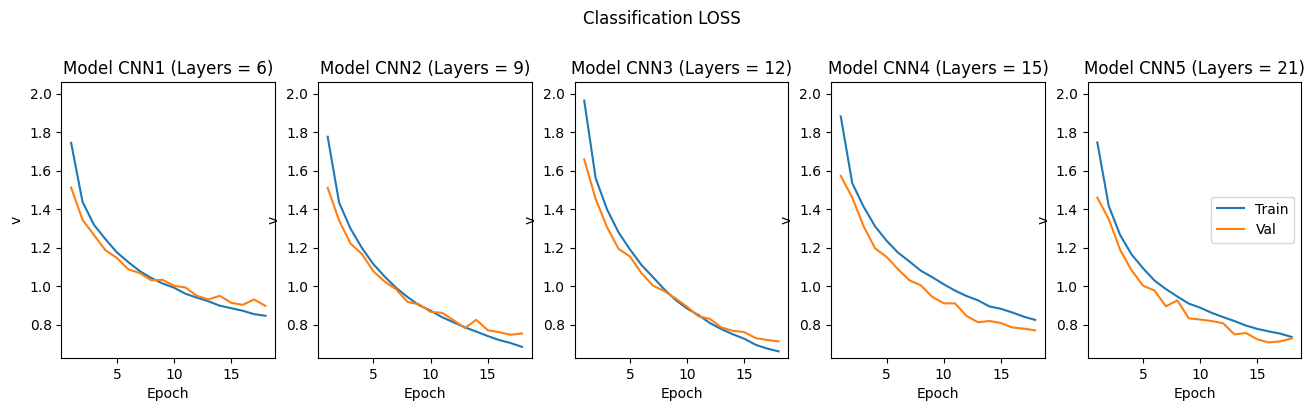

In [22]:
perform_plot(history_list, cnns, epoch, metrics=['loss', 'val_loss'])

## Predict Unseen Image

In [ ]:
img_url_path = "https://raw.githubusercontent.com/kavehmahdavi/TF_Portfolio/main/image_classification/images/test01.png"
with open("images/file01.jpg", "wb") as output:
    resource = urllib.request.urlopen(img_url_path)
    output.write(resource.read())
_predict("images/test01.png", cnns, classes)

## Save the Best Model

I save all these models for future use.

In [25]:
for _cnn in cnns:
    cnn5.save("saved_models/{}.h5".format(_cnn.name))

## Load Model to Inference

Significantly, the model **CNN3** shows outstanding performance, therefore I select it for the production.

In [44]:
# Load model
production_model = load_model("saved_models/CNN3.h5")

1/1 [==============================] - 0s 28ms/step
Predictions of these images are:


,unknown00,unknown01,unknown02,unknown03
airplane,0.819914,0.406586,0.000752,0.016166
automobile,0.000097,0.059467,0.000002,0.000012
bird,0.046165,0.001216,0.992904,0.001772
cat,0.002480,0.002003,0.001168,0.016606
deer,0.073671,0.000766,0.003969,0.504406
dog,0.000123,0.000008,0.000281,0.023721
frog,0.001625,0.029643,0.000728,0.001719
horse,0.000015,0.000042,0.000156,0.000062
ship,0.055438,0.495872,0.000032,0.432789
truck,0.000472,0.004398,0.000008,0.002748


The images given as input is:


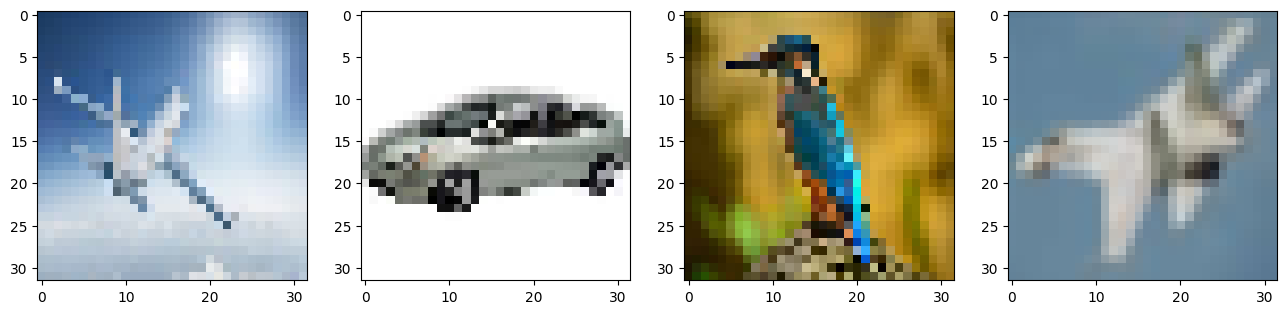

In [45]:
# Load unseen images
imgs_url_path = {
    'unknown00': 'https://raw.githubusercontent.com/kavehmahdavi/TF_Portfolio/main/image_classification/images/unknown01.png',
    'unknown01': 'https://raw.githubusercontent.com/kavehmahdavi/TF_Portfolio/main/image_classification/images/unknown02.png',
    'unknown02': 'https://raw.githubusercontent.com/kavehmahdavi/TF_Portfolio/main/image_classification/images/unknown03.png',
    'unknown03': 'https://raw.githubusercontent.com/kavehmahdavi/TF_Portfolio/main/image_classification/images/test01.png'}

for key, value in imgs_url_path.items():
    with open("images/{}.jpg".format(key), "wb") as output:
        resource = urllib.request.urlopen(value)
        output.write(resource.read())

_predicts(production_model, imgs_url_path.keys(), classes)

## Conclusion

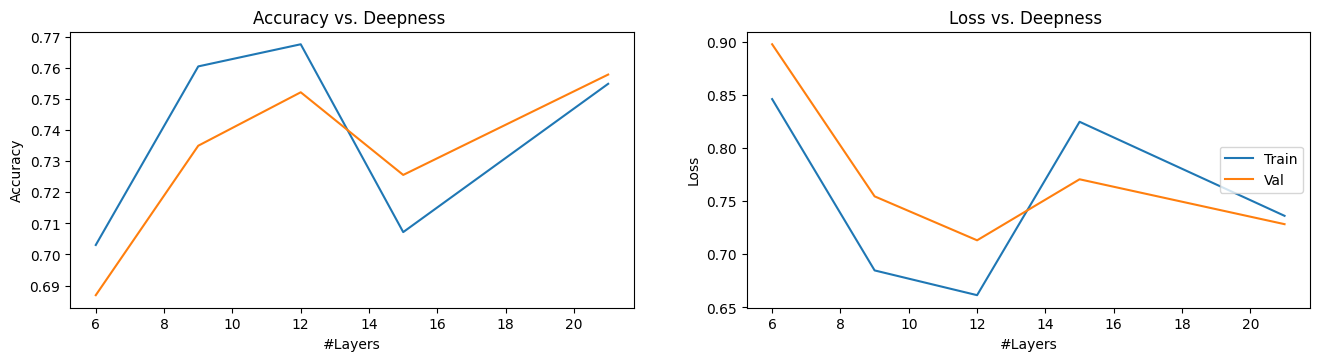

In [69]:
plot_deepness(history_list, cnns)

The deeper model could not be the best choose. As a result, Model **CNN3** could obtain approximately the same
accuracy level by almost half size of the deepest model **CNN5**.